In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import cv2
import os
from nltk import wordpunct_tokenize
import re
import matplotlib.pyplot as plt

In [2]:
# You need extract file ml1m.zip to folder ml1m before run code
movies_train = pd.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')


In [3]:
movies_train.reset_index(inplace= True)
movies_train

,movieid,title,genre
0,1650,Washington Square (1997),[Drama]
1,185,"Net, The (1995)","[Sci-Fi, Thriller]"
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]"
3,3204,"Boys from Brazil, The (1978)",[Thriller]
4,1901,Dear Jesse (1997),[Documentary]
...,...,...,...
3101,2539,Analyze This (1999),[Comedy]
3102,3038,"Face in the Crowd, A (1957)",[Drama]
3103,1832,Heaven's Burning (1997),"[Action, Drama]"
3104,657,Yankee Zulu (1994),"[Comedy, Drama]"


In [4]:
movies_test

,title,genre
movieid,,
3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]"
2067,Doctor Zhivago (1965),"[Drama, Romance, War]"
2651,Frankenstein Meets the Wolf Man (1943),[Horror]
2989,For Your Eyes Only (1981),[Action]
3415,"Mirror, The (Zerkalo) (1975)",[Drama]
...,...,...
2309,"Inheritors, The (Die Siebtelbauern) (1998)",[Drama]
2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]"
3255,"League of Their Own, A (1992)","[Comedy, Drama]"


In [5]:
movies_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3106 entries, 0 to 3105
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieid  3106 non-null   int64 
 1   title    3106 non-null   object
 2   genre    3106 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.9+ KB


In [6]:
movies_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, 3397 to 2555
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   777 non-null    object
 1   genre   777 non-null    object
dtypes: object(2)
memory usage: 18.2+ KB


# **Processing label**

In [7]:
movies_train.loc[(movies_train['title'].str.contains(',')) | (movies_train['title'].str.contains('\('))]

,movieid,title,genre
0,1650,Washington Square (1997),[Drama]
1,185,"Net, The (1995)","[Sci-Fi, Thriller]"
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]"
3,3204,"Boys from Brazil, The (1978)",[Thriller]
4,1901,Dear Jesse (1997),[Documentary]
...,...,...,...
3101,2539,Analyze This (1999),[Comedy]
3102,3038,"Face in the Crowd, A (1957)",[Drama]
3103,1832,Heaven's Burning (1997),"[Action, Drama]"
3104,657,Yankee Zulu (1994),"[Comedy, Drama]"


In [8]:
def normalize_title(title: str):
    #remove chars after '('
    idx = title.find('(')
    title = title[:idx].strip()
    
    # reposition word
    parts = title.split(',')
    if len(parts) > 1:
        # Move the word after ',' to the start of the title
        title = parts[1].strip() + ' ' + parts[0].strip()

    
    return title
# Example usage:
original_title = "Eighth Day, The (Le HuitiÃ¨me jour ) (1996)"
modified_title = normalize_title(original_title)

print("Original Title:", original_title)
print("Modified Title:", modified_title)

Original Title: Eighth Day, The (Le HuitiÃ¨me jour ) (1996)
Modified Title: The Eighth Day


In [9]:
movies_train['title'] = movies_train['title'].apply(normalize_title)


In [10]:
movies_train

,movieid,title,genre
0,1650,Washington Square,[Drama]
1,185,The Net,"[Sci-Fi, Thriller]"
2,1377,Batman Returns,"[Action, Adventure, Comedy, Crime]"
3,3204,The Boys from Brazil,[Thriller]
4,1901,Dear Jesse,[Documentary]
...,...,...,...
3101,2539,Analyze This,[Comedy]
3102,3038,A Face in the Crowd,[Drama]
3103,1832,Heaven's Burning,"[Action, Drama]"
3104,657,Yankee Zulu,"[Comedy, Drama]"


In [11]:
movies_train.loc[(movies_train['title'].str.contains(',')) | (movies_train['title'].str.contains('\('))]

,movieid,title,genre


# **Drop duplicate**

In [12]:
movies_train.drop_duplicates(subset= 'movieid')

,movieid,title,genre
0,1650,Washington Square,[Drama]
1,185,The Net,"[Sci-Fi, Thriller]"
2,1377,Batman Returns,"[Action, Adventure, Comedy, Crime]"
3,3204,The Boys from Brazil,[Thriller]
4,1901,Dear Jesse,[Documentary]
...,...,...,...
3101,2539,Analyze This,[Comedy]
3102,3038,A Face in the Crowd,[Drama]
3103,1832,Heaven's Burning,"[Action, Drama]"
3104,657,Yankee Zulu,"[Comedy, Drama]"


# **Check language**

In [13]:
import langid

In [14]:
def detect_language(text):
    lang, confidence = langid.classify(text)
    return lang

In [15]:
movies_train['language_code'] = movies_train['title'].apply(detect_language)

In [16]:
movies_train

,movieid,title,genre,language_code
0,1650,Washington Square,[Drama],en
1,185,The Net,"[Sci-Fi, Thriller]",en
2,1377,Batman Returns,"[Action, Adventure, Comedy, Crime]",en
3,3204,The Boys from Brazil,[Thriller],en
4,1901,Dear Jesse,[Documentary],en
...,...,...,...,...
3101,2539,Analyze This,[Comedy],en
3102,3038,A Face in the Crowd,[Drama],en
3103,1832,Heaven's Burning,"[Action, Drama]",en
3104,657,Yankee Zulu,"[Comedy, Drama]",de


In [17]:
movies_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3106 entries, 0 to 3105
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   movieid        3106 non-null   int64 
 1   title          3106 non-null   object
 2   genre          3106 non-null   object
 3   language_code  3106 non-null   object
dtypes: int64(1), object(3)
memory usage: 97.2+ KB


In [18]:
movies_train['language_code'].unique()

array(['en', 'es', 'mt', 'fi', 'fr', 'et', 'cs', 'hu', 'de', 'it', 'tr',
       'da', 'ro', 'nl', 'pl', 'lt', 'ga', 'eu', 'sl', 'sv', 'ca', 'ms',
       'eo', 'lv', 'pt', 'sk', 'cy', 'id', 'hr', 'is', 'bs'], dtype=object)

In [19]:
language_dict = {
    'en': 'English',
    'et': 'Estonian',
    'de': 'German',
    'id': 'Indonesian',
    'fi': 'Finnish',
    'it': 'Italian',
    'sl': 'Slovenian',
    'cs': 'Czech',
    'tr': 'Turkish',
    'es': 'Spanish',
    'da': 'Danish',
    'pl': 'Polish',
    'fr': 'French',
    'gl': 'Galician',
    'pt': 'Portuguese',
    'mg': 'Malagasy',
    'ro': 'Romanian',
    'eu': 'Basque',
    'nl': 'Dutch',
    'sv': 'Swedish',
    'zh': 'Chinese',
    'ca': 'Catalan',
    'lt': 'Lithuanian',
    'xh': 'Xhosa',
    'eo': 'Esperanto',
    'lv': 'Latvian',
    'ms': 'Malay',
    'sk': 'Slovak',
    'sw': 'Swahili',
    'cy': 'Welsh',
    'mt': 'Maltese',
    'tl': 'Tagalog',
    'an': 'Aragonese',
    'hr': 'Croatian',
    'is': 'Icelandic',
    'bs': 'Bosnian',
    'ga': 'Irish',
    'no': 'Norwegian',
    'rw': 'Kinyarwanda',
    'unk': 'Unknown'
}


In [20]:
movies_train['language'] = movies_train['language_code'].map(language_dict)

<Axes: xlabel='language'>

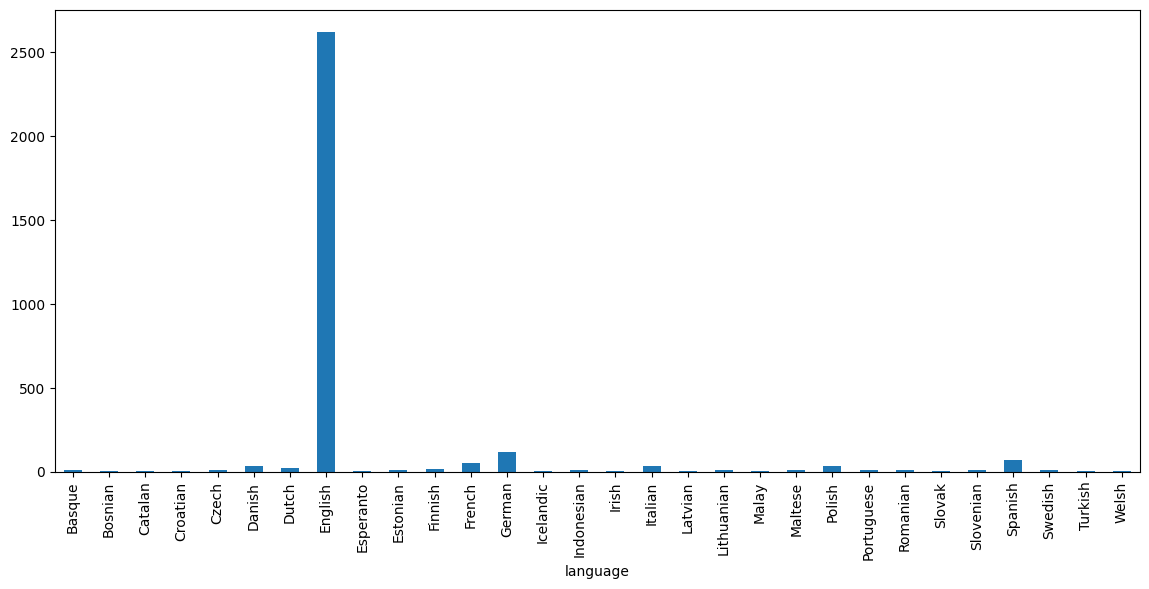

In [21]:
movies_train.groupby('language')['title'].count().plot(kind= 'bar', figsize=(14, 6))


In [22]:
movies_train.loc[movies_train['language'] == 'Latvian']

,movieid,title,genre,language_code,language
657,3574,Carnosaur 3: Primal Species,"[Horror, Sci-Fi]",lv,Latvian
824,2050,Herbie Goes Bananas,"[Adventure, Children's, Comedy]",lv,Latvian
1182,1078,Bananas,"[Comedy, War]",lv,Latvian
2324,756,Carmen Miranda: Bananas Is My Business,[Documentary],lv,Latvian


In [23]:
movies_train.loc[movies_train['language_code'] != 'en']

,movieid,title,genre,language_code,language
7,2382,Police Academy 5: Assignment: Miami Beach,[Comedy],es,Spanish
10,794,Midnight Dancers,"[Comedy, Drama]",mt,Maltese
11,347,Bitter Moon,[Drama],fi,Finnish
24,2121,Cujo,"[Horror, Thriller]",fr,French
40,2940,Gilda,[Film-Noir],et,Estonian
...,...,...,...,...,...
3086,2154,How Stella Got Her Groove Back,"[Drama, Romance]",it,Italian
3092,3356,Condo Painting,[Documentary],it,Italian
3094,3918,Hellbound: Hellraiser II,[Horror],fr,French
3104,657,Yankee Zulu,"[Comedy, Drama]",de,German


# **Check label**

In [24]:
genre_df = pd.DataFrame(movies_train['genre'].explode())

count_genre = genre_df['genre'].value_counts()
count_genre

genre
Drama          1294
Comedy          953
Action          413
Thriller        386
Romance         377
Horror          268
Adventure       235
Sci-Fi          228
Children's      203
Crime           180
War             118
Musical         101
Documentary      97
Mystery          88
Animation        84
Fantasy          61
Western          54
Film-Noir        38
Name: count, dtype: int64

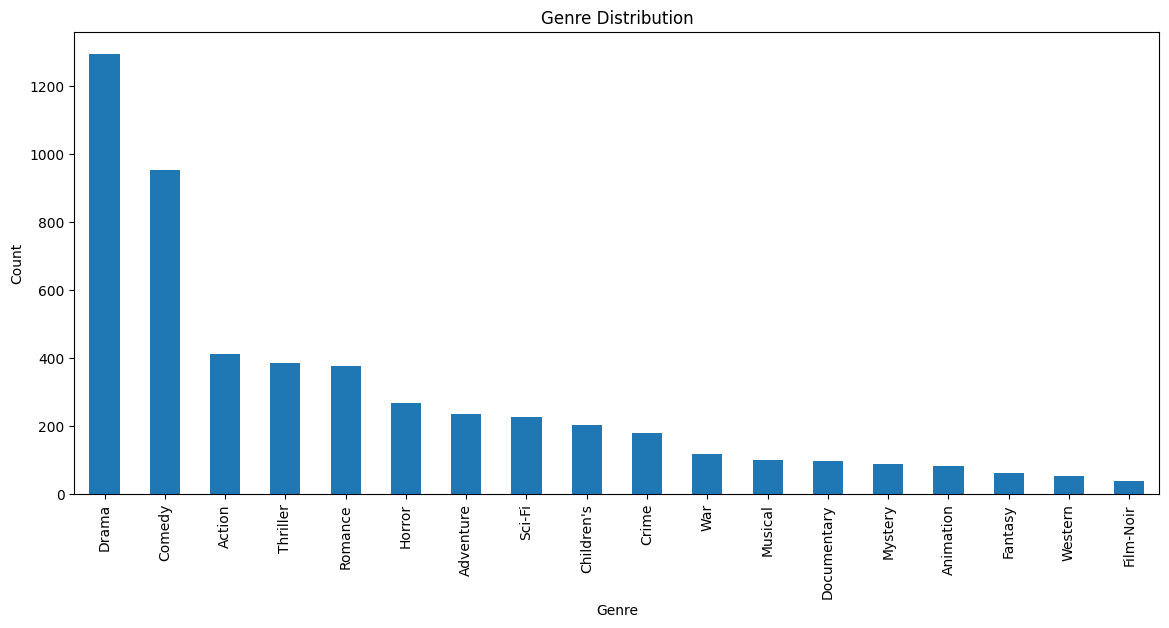

In [25]:

# Plot the count of each genre
plt.figure(figsize=(12, 6))
count_genre.plot(kind= 'bar', figsize= (14, 6))
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

# **Balance data**

In [26]:
# count the most popular genre
max_cnt = max(count_genre.values)
max_cnt

1294

In [27]:
# define augment times for each genre
augment_dict = {}
for idx, value in count_genre.items():
    augment_dict[idx] = (max_cnt // value) - 1
    
augment_dict

{'Drama': 0,
 'Comedy': 0,
 'Action': 2,
 'Thriller': 2,
 'Romance': 2,
 'Horror': 3,
 'Adventure': 4,
 'Sci-Fi': 4,
 "Children's": 5,
 'Crime': 6,
 'War': 9,
 'Musical': 11,
 'Documentary': 12,
 'Mystery': 13,
 'Animation': 14,
 'Fantasy': 20,
 'Western': 22,
 'Film-Noir': 33}

In [28]:
def get_augment_time(genre: list[str])-> int:
    '''
    Define number of augment times for each film
    '''
    sum = 0
    for g in genre:
        if g in ['Drama', 'Comedy']:  return 0
        sum += augment_dict[g]
        
    sum = sum // len(genre)
    return sum

In [29]:
movies_train['augment_time'] = movies_train['genre'].apply(get_augment_time)

In [30]:
movies_train

,movieid,title,genre,language_code,language,augment_time
0,1650,Washington Square,[Drama],en,English,0
1,185,The Net,"[Sci-Fi, Thriller]",en,English,3
2,1377,Batman Returns,"[Action, Adventure, Comedy, Crime]",en,English,0
3,3204,The Boys from Brazil,[Thriller],en,English,2
4,1901,Dear Jesse,[Documentary],en,English,12
...,...,...,...,...,...,...
3101,2539,Analyze This,[Comedy],en,English,0
3102,3038,A Face in the Crowd,[Drama],en,English,0
3103,1832,Heaven's Burning,"[Action, Drama]",en,English,0
3104,657,Yankee Zulu,"[Comedy, Drama]",de,German,0


In [31]:
movies_train.loc[movies_train['augment_time'] == movies_train['augment_time'].max()]

,movieid,title,genre,language_code,language,augment_time
40,2940,Gilda,[Film-Noir],et,Estonian,33
492,3292,The Big Combo,[Film-Noir],en,English,33
1386,2066,Out of the Past,[Film-Noir],en,English,33
1487,1153,Raw Deal,[Film-Noir],en,English,33
1703,1154,T-Men,[Film-Noir],en,English,33
2004,3380,Railroaded!,[Film-Noir],en,English,33
2601,3121,The Hitch-Hiker,[Film-Noir],en,English,33
2729,2727,Killer's Kiss,[Film-Noir],en,English,33
2744,922,Sunset Blvd.,[Film-Noir],en,English,33


In [32]:
%pip install transformers nlpaug

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import nlpaug.augmenter.word as naw

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
aug_swap = naw.RandomWordAug(action= 'swap', aug_min= 1, aug_max= 3)     # Swap word randomly
aug_del = naw.RandomWordAug(action= 'delete', aug_min= 1, aug_max= 1)     # Delete word randomly
aug_syn = naw.SynonymAug(aug_src= 'wordnet', lang= 'eng')                # Substitute word by WordNet's synonym


In [36]:
text = 'The Boys'
augmented_text = aug_del.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)
print(type(augmented_text))


Original:
The Boys
Augmented Text:
['Boys']
<class 'list'>


In [37]:
augmented_df = pd.DataFrame(columns= movies_train.columns)
for idx, row in movies_train.iterrows():
    augment_time = row['augment_time']
    max_title_len = len(row['title'].split(' '))
    n = min (max_title_len, augment_time)
    for i in range(augment_time):
        aug_type = np.random.randint(0, 3)
        new_row = row
        if aug_type == 0:
            new_row['title'] = aug_swap.augment(row['title'])[0]
            
        if aug_type == 1:
            new_row['title'] = aug_del.augment(row['title'])[0]
            
        else:
            new_row['title'] = aug_syn.augment(row['title'])[0]
        augmented_df.loc[len(augmented_df.index)] = new_row


In [38]:
augmented_df

,movieid,title,genre,language_code,language,augment_time
0,185,The Last,"[Sci-Fi, Thriller]",en,English,3
1,185,Last,"[Sci-Fi, Thriller]",en,English,3
2,185,Last,"[Sci-Fi, Thriller]",en,English,3
3,3204,Son from the Brazil,[Thriller],en,English,2
4,3204,Son from the,[Thriller],en,English,2
...,...,...,...,...,...,...
6040,1750,Adept,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
6041,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
6042,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
6043,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8


In [39]:
augmented_df = augmented_df[augmented_df['title'].str.lower() != 'the']
augmented_df

,movieid,title,genre,language_code,language,augment_time
0,185,The Last,"[Sci-Fi, Thriller]",en,English,3
1,185,Last,"[Sci-Fi, Thriller]",en,English,3
2,185,Last,"[Sci-Fi, Thriller]",en,English,3
3,3204,Son from the Brazil,[Thriller],en,English,2
4,3204,Son from the,[Thriller],en,English,2
...,...,...,...,...,...,...
6040,1750,Adept,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
6041,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
6042,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
6043,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8


In [40]:
augmented_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5875 entries, 0 to 6044
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   movieid        5875 non-null   object
 1   title          5875 non-null   object
 2   genre          5875 non-null   object
 3   language_code  5875 non-null   object
 4   language       5866 non-null   object
 5   augment_time   5875 non-null   object
dtypes: object(6)
memory usage: 321.3+ KB


In [44]:
augmented_df = augmented_df.loc[augmented_df['title'].str.len() != 1]
augmented_df

,movieid,title,genre,language_code,language,augment_time
0,185,The Last,"[Sci-Fi, Thriller]",en,English,3
1,185,Last,"[Sci-Fi, Thriller]",en,English,3
2,185,Last,"[Sci-Fi, Thriller]",en,English,3
3,3204,Son from the Brazil,[Thriller],en,English,2
4,3204,Son from the,[Thriller],en,English,2
...,...,...,...,...,...,...
6040,1750,Adept,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
6041,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
6042,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
6043,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8


In [45]:
movies_train = pd.concat([movies_train, augmented_df], ignore_index= True)

In [46]:
movies_train

,movieid,title,genre,language_code,language,augment_time
0,1650,Washington Square,[Drama],en,English,0
1,185,The Net,"[Sci-Fi, Thriller]",en,English,3
2,1377,Batman Returns,"[Action, Adventure, Comedy, Crime]",en,English,0
3,3204,The Boys from Brazil,[Thriller],en,English,2
4,1901,Dear Jesse,[Documentary],en,English,12
...,...,...,...,...,...,...
8776,1750,Adept,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
8777,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
8778,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8
8779,1750,Good,"[Adventure, Children's, Fantasy, Sci-Fi]",es,Spanish,8


In [47]:
movies_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8781 entries, 0 to 8780
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   movieid        8781 non-null   object
 1   title          8781 non-null   object
 2   genre          8781 non-null   object
 3   language_code  8781 non-null   object
 4   language       8767 non-null   object
 5   augment_time   8781 non-null   object
dtypes: object(6)
memory usage: 411.7+ KB


In [48]:
genre_df = pd.DataFrame(movies_train['genre'].explode())

count_genre = genre_df['genre'].value_counts()
count_genre

genre
Drama          1294
Action         1288
Thriller       1270
Documentary    1113
Adventure       999
Children's      969
Comedy          953
Horror          931
Sci-Fi          919
Crime           657
Western         646
Animation       642
Film-Noir       599
Musical         590
Romance         589
Mystery         485
Fantasy         390
War             387
Name: count, dtype: int64

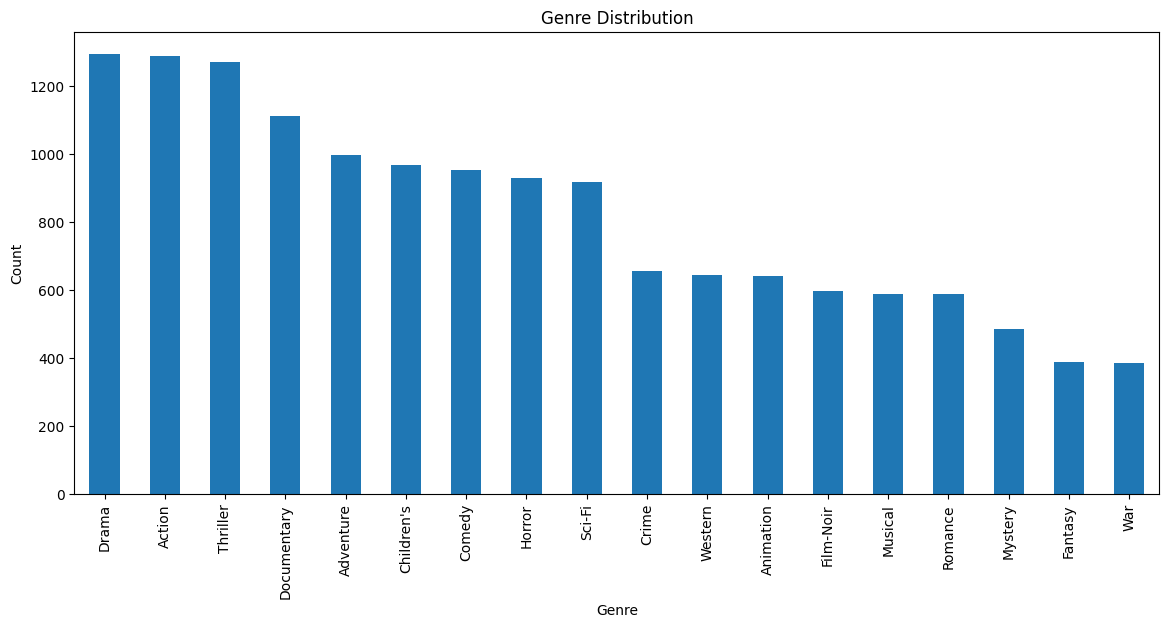

In [49]:
# Plot the count of each genre
plt.figure(figsize=(12, 6))
count_genre.plot(kind= 'bar', figsize= (14, 6))
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

# **Save data**

In [54]:
import os
path = 'ml1m/content/dataset/cleaned_data'
os.makedirs(path, exist_ok=True)
movies_train.to_csv(os.path.join(path, 'movies_train.csv'), index=False, columns= ['movieid','title', 'genre'])

In [55]:
movies_test

,title,genre
movieid,,
3397,The Great Muppet Caper,"[Children's, Comedy]"
2067,Doctor Zhivago,"[Drama, Romance, War]"
2651,Frankenstein Meets the Wolf Man,[Horror]
2989,For Your Eyes Only,[Action]
3415,The Mirror,[Drama]
...,...,...
2309,The Inheritors,[Drama]
2421,Part II Karate Kid,"[Action, Adventure, Drama]"
3255,A League of Their Own,"[Comedy, Drama]"


In [56]:
movies_test['title'] = movies_test['title'].apply(normalize_title)

In [57]:
movies_test

,title,genre
movieid,,
3397,The Great Muppet Cape,"[Children's, Comedy]"
2067,Doctor Zhivag,"[Drama, Romance, War]"
2651,Frankenstein Meets the Wolf Ma,[Horror]
2989,For Your Eyes Onl,[Action]
3415,The Mirro,[Drama]
...,...,...
2309,The Inheritor,[Drama]
2421,Part II Karate Ki,"[Action, Adventure, Drama]"
3255,A League of Their Ow,"[Comedy, Drama]"


In [58]:
path = 'ml1m/content/dataset/cleaned_data'
os.makedirs(path, exist_ok=True)
movies_test.to_csv(os.path.join(path, 'movies_test.csv'), index=True)